In [1]:
import pandas as pd
import re
import requests
from bs4 import BeautifulSoup
import re
import numpy as np
import json

In [2]:
news = pd.read_json('C:/Users/user/Desktop/pre_삼성전자_연합인포맥스.json')

크롤링코드(수정종가 반영x)

In [7]:
dates = []
prices = []

for j in range(1,427):
    res = requests.get("https://finance.naver.com/item/sise_day.nhn?code=005930&page={}".format(j))
    bs = BeautifulSoup(res.text, "html.parser")
    # print(bs.text)
    date = bs.select('span.p10')
    price = bs.select('span.p11')

    for i in range(len(date)):
        dates.append(date[i].text)
        prices.append(price[6*i].text)

data = np.array([dates,prices])
# print(data)
stock = pd.DataFrame(data.T, columns=['날짜','종가'])
stock.head()

,날짜,종가
0,2020.10.22,"60,000"
1,2020.10.21,"60,900"
2,2020.10.20,"60,900"
3,2020.10.19,"60,000"
4,2020.10.16,"59,500"


수정종가 반영된 주가 시각화

In [3]:
stock = pd.read_csv('C:/Users/user/Desktop/samsung_stock_price.csv')
stock

,Unnamed: 0,Date,Open,High,Low,Close,Adj Close,Volume
0,0,2000-01-04,6000.0,6110.0,5660.0,6110.0,0.090599,74195000.0
1,1,2000-01-05,5800.0,6060.0,5520.0,5580.0,0.082740,74680000.0
2,2,2000-01-06,5750.0,5780.0,5580.0,5620.0,0.083333,54390000.0
3,3,2000-01-07,5560.0,5670.0,5360.0,5540.0,0.082147,40305000.0
4,4,2000-01-10,5600.0,5770.0,5580.0,5770.0,0.085558,46880000.0
...,...,...,...,...,...,...,...,...
5215,5215,2020-09-24,57700.0,58600.0,57600.0,57800.0,57800.000000,17564020.0
5216,5216,2020-09-25,57700.0,58200.0,57700.0,57900.0,57900.000000,11444683.0
5217,5217,2020-09-28,58300.0,58800.0,57900.0,58200.0,58200.000000,12614080.0
5218,5218,2020-09-29,58300.0,59000.0,58200.0,58200.0,58200.000000,15503563.0


In [4]:
stock.rename(columns = {'Date': 'date'}, inplace = True)
stock.drop(['Unnamed: 0'], axis='columns', inplace=True)

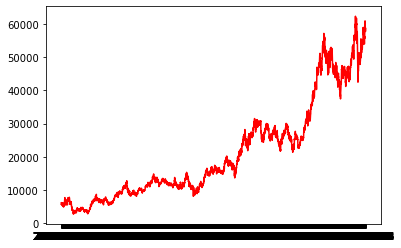

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.plot(stock.Date, stock.Close,color='r')
plt.show()

주가 라벨링

In [5]:
# 중간중간 빈날짜를 채워줘야함.
from datetime import datetime, timedelta
# start_date부터 end_date까지 날짜 리스트 생성
start_date = datetime.strptime('20010104', '%Y%m%d')
end_date = datetime.strptime('20201005', '%Y%m%d')

str_date_list = []
while start_date.strftime('%Y%m%d') != end_date.strftime('%Y%m%d'): # start_date가 end_date랑 같아지기 전까지 1씩 늘어나면서 리스트에 추가
    str_date_list.append(start_date.strftime('%Y-%m-%d'))
    start_date += timedelta(days=1)
str_date_list.append(end_date.strftime('%Y-%m-%d')) # end_date 포함안됐으므로 따로 추가
    
date_list=np.array([str_date_list])
all_date  = pd.DataFrame(date_list.T, columns=['date'])
# print(all_date)

In [6]:
df = pd.merge(stock,all_date, on='date', how='outer') # 기존크롤링데이터와 전체날짜를 date기준으로 outer 조인
df_stock = df.sort_values(by='date' ,ascending=False).fillna(method='bfill') # 내림차순으로 정렬후, 결측치는 가장 최근 과거 값으로 대입
df_stock = df_stock.reset_index(drop=True)

In [7]:
df_stock['stock_after']=df_stock['Close']
df_stock['price_gap']=''

In [8]:
# 1일 후 주가를 stock_after 칼럼에 shift
df_stock.stock_after = df_stock.stock_after.shift(1)
df_stock

,date,Open,High,Low,Close,Adj Close,Volume,stock_after,price_gap
0,2020-10-05,57500.0,59200.0,57500.0,58700.0,58700.000000,19529988.0,NaN,
1,2020-10-04,58300.0,59000.0,58200.0,58200.0,58200.000000,15503563.0,58700.0,
2,2020-10-03,58300.0,59000.0,58200.0,58200.0,58200.000000,15503563.0,58200.0,
3,2020-10-02,58300.0,59000.0,58200.0,58200.0,58200.000000,15503563.0,58200.0,
4,2020-10-01,58300.0,59000.0,58200.0,58200.0,58200.000000,15503563.0,58200.0,
...,...,...,...,...,...,...,...,...,...
7472,2000-01-10,5600.0,5770.0,5580.0,5770.0,0.085558,46880000.0,5770.0,
7473,2000-01-07,5560.0,5670.0,5360.0,5540.0,0.082147,40305000.0,5770.0,
7474,2000-01-06,5750.0,5780.0,5580.0,5620.0,0.083333,54390000.0,5540.0,
7475,2000-01-05,5800.0,6060.0,5520.0,5580.0,0.082740,74680000.0,5620.0,


In [9]:
df_stock['label']=''

In [10]:
df_stock['price_gap'] = df_stock['stock_after']/df_stock['Close']-1

In [11]:
df_stock

,date,Open,High,Low,Close,Adj Close,Volume,stock_after,price_gap,label
0,2020-10-05,57500.0,59200.0,57500.0,58700.0,58700.000000,19529988.0,NaN,NaN,
1,2020-10-04,58300.0,59000.0,58200.0,58200.0,58200.000000,15503563.0,58700.0,0.008591,
2,2020-10-03,58300.0,59000.0,58200.0,58200.0,58200.000000,15503563.0,58200.0,0.000000,
3,2020-10-02,58300.0,59000.0,58200.0,58200.0,58200.000000,15503563.0,58200.0,0.000000,
4,2020-10-01,58300.0,59000.0,58200.0,58200.0,58200.000000,15503563.0,58200.0,0.000000,
...,...,...,...,...,...,...,...,...,...,...
7472,2000-01-10,5600.0,5770.0,5580.0,5770.0,0.085558,46880000.0,5770.0,0.000000,
7473,2000-01-07,5560.0,5670.0,5360.0,5540.0,0.082147,40305000.0,5770.0,0.041516,
7474,2000-01-06,5750.0,5780.0,5580.0,5620.0,0.083333,54390000.0,5540.0,-0.014235,
7475,2000-01-05,5800.0,6060.0,5520.0,5580.0,0.082740,74680000.0,5620.0,0.007168,


In [12]:
for i in range(len(df_stock)):
    if df_stock['price_gap'][i] > 0:
        df_stock['label'][i] = df_stock['label'][i].replace('', '1')

    elif df_stock['price_gap'][i] < 0:
        df_stock['label'][i] = df_stock['label'][i].replace('', '0')
    else:
        df_stock['label'][i] = df_stock['label'][i].replace('', '10')

<ipython-input-12-5876e1a67761>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock['label'][i] = df_stock['label'][i].replace('', '10')
<ipython-input-12-5876e1a67761>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock['label'][i] = df_stock['label'][i].replace('', '1')
<ipython-input-12-5876e1a67761>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock['label'][i] = df_stock['label'][i].replace('', '0')


In [13]:
df_stock

,date,Open,High,Low,Close,Adj Close,Volume,stock_after,price_gap,label
0,2020-10-05,57500.0,59200.0,57500.0,58700.0,58700.000000,19529988.0,NaN,NaN,10
1,2020-10-04,58300.0,59000.0,58200.0,58200.0,58200.000000,15503563.0,58700.0,0.008591,1
2,2020-10-03,58300.0,59000.0,58200.0,58200.0,58200.000000,15503563.0,58200.0,0.000000,10
3,2020-10-02,58300.0,59000.0,58200.0,58200.0,58200.000000,15503563.0,58200.0,0.000000,10
4,2020-10-01,58300.0,59000.0,58200.0,58200.0,58200.000000,15503563.0,58200.0,0.000000,10
...,...,...,...,...,...,...,...,...,...,...
7472,2000-01-10,5600.0,5770.0,5580.0,5770.0,0.085558,46880000.0,5770.0,0.000000,10
7473,2000-01-07,5560.0,5670.0,5360.0,5540.0,0.082147,40305000.0,5770.0,0.041516,1
7474,2000-01-06,5750.0,5780.0,5580.0,5620.0,0.083333,54390000.0,5540.0,-0.014235,0
7475,2000-01-05,5800.0,6060.0,5520.0,5580.0,0.082740,74680000.0,5620.0,0.007168,1


In [14]:
label= df_stock[['date','Close','stock_after','price_gap','label']]

In [17]:
label.dropna(axis=0, inplace=True)

<ipython-input-17-02c8eb8c8043>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  label.dropna(axis=0, inplace=True)


In [18]:
news['date'] = pd.to_datetime(news['date'], format="%Y-%m-%d")
label['date'] = pd.to_datetime(label['date'], format="%Y-%m-%d")

<ipython-input-18-f071073e4aa0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  label['date'] = pd.to_datetime(label['date'], format="%Y-%m-%d")


In [19]:
news_label = pd.merge(news,label, on='date', how='inner')
news_label

,Unnamed: 0,date,office,url,text,title,count_str,Close,stock_after,price_gap,label
0,477114,2003-08-01,연합인포맥스,https://news.naver.com/main/read.nhn?mode=LSD&...,하이닉스 주가가 급반등했다. 1일 오후 2시23분 현재 하이닉스는 전날보다 1천1...,"하이닉스, 주가 급반등",508,8520.0,8520.0,0.000000,10
1,477116,2003-08-01,연합인포맥스,https://news.naver.com/main/read.nhn?mode=LSD&...,거래소시장에서 종합지수가 美 경제지표의 호전에 고무된 외국인 매수로 연중 고점을 ...,"<마감> 거래소,'730선 넘어서자'..연중 고점 경신",1134,8520.0,8520.0,0.000000,10
2,477121,2003-08-01,연합인포맥스,https://news.naver.com/main/read.nhn?mode=LSD&...,반도체주들이 강보합권에 개장했다. 1일 오전 9시5분 현재 삼성전자는 전날보다 3...,"반도체주, 반등...미증시 강보합",507,8520.0,8520.0,0.000000,10
3,477075,2003-08-01,연합인포맥스,https://news.naver.com/main/read.nhn?mode=LSD&...,1일 전기전자업종은 외국인 매수에 힘입어 삼성전자가 연중 고점을 경신하는 등 대부...,"<전기전자업종> 삼성전자, 연중 최고치 경신",699,8520.0,8520.0,0.000000,10
4,477228,2003-08-04,연합인포맥스,https://news.naver.com/main/read.nhn?mode=LSD&...,반도체주들이 약세권에 개장했다. 4일 오전 9시5분 현재 삼성전자는 전날보다 5천...,"반도체주, 하락...하이닉스 보합권 등락",578,8430.0,8560.0,0.015421,1
...,...,...,...,...,...,...,...,...,...,...,...
15673,434091,2020-09-28,연합인포맥스,https://news.einfomax.co.kr/news/articleView.h...,코스피는 신종 코로나바이러스 감염증 재확산 우려에도 전일 미국 증시 상승 영향에 ...,"코스피, 美증시 호조에 1%대 상승…2,300선 회복",1103,58200.0,58200.0,0.000000,10
15674,434081,2020-09-28,연합인포맥스,https://news.einfomax.co.kr/news/articleView.h...,코스피는 외국인과 기관의 매수에 오후 상승 폭을 키웠다. 28일 코스피는 오후 ...,"코스피, 1.5%대 상승…外人·기관 매수 지속",856,58200.0,58200.0,0.000000,10
15675,434127,2020-09-29,연합인포맥스,https://news.einfomax.co.kr/news/articleView.h...,코스피는 연휴를 앞두고 기관이 장중 순매수 기조를 이어간 영향으로 상승 마감했다....,"코스피, 0.8%대 상승 마감…기관 사흘째 순매수",986,58200.0,58200.0,0.000000,10
15676,434132,2020-09-29,연합인포맥스,https://news.einfomax.co.kr/news/articleView.h...,코스피는 미국 추가 부양책 합의 기대로 상승하고 있다. 29일 코스피는 9시 6...,"코스피, 개인·기관 매수에 1%대 상승…美 추가 부양책 기대",1073,58200.0,58200.0,0.000000,10


In [20]:
news_label.to_csv('C:/Users/user/Desktop/sample_label_by1.csv', encoding='utf-8', index=False)